# TP 1: LDA/QDA y optimización matemática de modelos

Integrantes:

- Brazón, Josmar

- Pardo, Sebastián

- González, Martín

- Losada, Ricardo

## Implementaciones y Benchmarks

### Colab

In [1]:
# Ajusta de entorno en Colab

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:

    !pip install -q numpy pandas matplotlib scipy scikit-learn==1.6.1

    !rm -rf /content/amia_tp1
    !git clone -q -b para_entregar --single-branch https://github.com/spardo83/amia_tp1.git /content/amia_tp1

    # Asegurar los __init__.py en el LUGAR CORRECTO (dentro del repo clonado)
    !touch /content/amia_tp1/base/__init__.py
    !touch /content/amia_tp1/utils/__init__.py
    !ls -lah /content/amia_tp1/base | head -n 20
    !ls -lah /content/amia_tp1/utils | head -n 20

    import sys, importlib, os
    assert os.path.isfile("/content/amia_tp1/base/qda.py"), "No encuentro base/qda.py en el repo clonado"
    sys.path = ['/content/amia_tp1'] + [p for p in sys.path if p != '/content/amia_tp1']
    importlib.invalidate_caches()

### Librerias

In [2]:
# Importar librerias

import numpy as np
import matplotlib.pyplot as plt

from base.qda import QDA, TensorizedQDA
from base.cholesky import QDA_Chol1, QDA_Chol2, QDA_Chol3
from utils.bench import Benchmark
from utils.datasets import get_wine_dataset, label_encode

### Dataset Wine

In [3]:
# levantamos el dataset Wine, que tiene 13 features y 178 observaciones en total

X_full, y_full = get_wine_dataset()

# encodeamos a número las clases

y_full_encoded = label_encode(y_full)

### Configuración Benchmark

In [4]:
# generamos el benchmark

b = Benchmark(
    X_full, y_full_encoded,
    n_runs = 1000,
    warmup = 20,
    mem_runs = 200,
    test_sz = 0.3,
    same_splits = False
)

Benching params:
Total runs: 1220
Warmup runs: 20
Peak Memory usage runs: 200
Running time runs: 1000
Train size rows (approx): 125
Test size rows (approx): 53
Test size fraction: 0.3


### QDA y TensorizedQDA

In [5]:
# bencheamos un par
to_bench = [QDA, TensorizedQDA]

for model in to_bench:
    b.bench(model)

QDA (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### Implementación FaterQDA

In [6]:
class FasterQDA(TensorizedQDA):
    def fit(self, X, y):
        # y como vector plano
        y = y.flatten() if y.ndim > 1 else y

        # priors en log
        counts = np.bincount(y)
        self.log_a_priori = np.log(counts / counts.sum())

        # parámetros del modelo (llena inv_covs/means y sus stacks tensoriales)
        self._fit_params(X, y)

    def predict(self, X):
        # Convención del TP: X tiene forma (p, n)
        p, n = X.shape

        # 1) Restamos medias por clase a TODAS las observaciones a la vez
        #    self.tensor_means: (K, p, 1)  -> broadcast con X[None, :, :] (1, p, n)
        diffs = X[None, :, :] - self.tensor_means   # -> (K, p, n)

        # 2) Forma cuadrática: (x-μ)^T Σ^{-1} (x-μ) en bloque
        #    inv: (K, p, p)  y diffs: (K, p, n)
        #    resultado intermedio: (K, p, n)
        left = np.einsum('kpq,kqn->kpn', self.tensor_inv_cov, diffs)

        #    producto elemento a elemento y suma en "p" -> (K, n)
        quad = np.einsum('kpn,kpn->kn', diffs, left)

        # 3) Términos extra por clase
        log_dets = np.log(np.linalg.det(self.tensor_inv_cov))      # (K,)
        scores = (-0.5 * quad - 0.5 * log_dets[:, None] + self.log_a_priori[:, None]).T  # (n, K)

        # 4) Elegimos la clase ganadora por observación
        return np.argmax(scores, axis=1).reshape(-1, 1)
    
b.bench(FasterQDA)


FasterQDA (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### EfficientQDA

In [7]:
class EfficientQDA(TensorizedQDA):
    def fit(self, X, y):
        # y vector plano
        y = y.flatten() if y.ndim > 1 else y
        # log-priors por clase
        counts = np.bincount(y)
        self.log_a_priori = np.log(counts / counts.sum())
        # parámetros (inv covs y medias apiladas)
        self._fit_params(X, y)
        # opcional
        self.n_classes_ = len(self.log_a_priori)
        return self

    def predict(self, X):
        # *** Convención del TP: X debe ser (p, n) ***
        # Si viniera como (n, p), lo giro para que p coincida con self.tensor_means
        p_expected = self.tensor_means.shape[1]  # (K, p, 1)
        if X.shape[0] != p_expected:
            X = X.T  # ahora X es (p, n)

        # diffs: (K, p, n)  ← restamos medias por clase a TODAS las observaciones
        diffs = X[None, :, :] - self.tensor_means   # (K, p, n)

        # Aplicamos Σ^{-1} sin formar n×n:
        # left = Σ^{-1} * diffs  → (K, p, n)
        left = np.einsum('kpq,kqn->kpn', self.tensor_inv_cov, diffs)

        # Forma cuadrática por clase y observación: sumo en la dimensión p
        # quad[k, i] = sum_p diffs[k,p,i] * left[k,p,i]
        quad = np.einsum('kpn,kpn->kn', diffs, left)  # (K, n)

        # Términos por clase
        log_dets = np.log(np.linalg.det(self.tensor_inv_cov))      # (K,)
        scores = (-0.5 * quad
                  - 0.5 * log_dets[:, None]
                  + self.log_a_priori[:, None])                    # (K, n)

        # Ganadora por observación
        return np.argmax(scores, axis=0).reshape(-1, 1)
    
b.bench(EfficientQDA)


EfficientQDA (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### Chol1 Chol2 y Chol3

In [8]:
b.bench(QDA_Chol1)
b.bench(QDA_Chol2)
b.bench(QDA_Chol3)

QDA_Chol1 (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### TensorizedChol

In [9]:
class TensorizedChol(QDA_Chol1):
    __name__ = "TensorizedChol"

    def _fit_params(self, X, y):
        # Reutilizamos el ajuste de QDA_Chol1 (calcula self.L_invs y self.means)
        super()._fit_params(X, y)

        # Tensores para vectorizar
        self.tensor_L_invs = np.stack(self.L_invs)              # (k, p, p)
        self.tensor_means  = np.stack(self.means)               # (k, p, 1)

        # log(prod(diag(L_inv))) por clase (vectorizado)
        diag_Linv = np.diagonal(self.tensor_L_invs, axis1=1, axis2=2)   # (k, p)
        self.log_diag_Linv_prod = np.sum(np.log(diag_Linv), axis=1)     # (k,)

    def _predict_log_conditionals(self, x):
        # x: (p,1) o (p,), lo normalizamos a (p,1)
        x = x.reshape(-1, 1)
        # (k, p, 1)
        unbiased = x[None, :, :] - self.tensor_means
        # y = L_inv @ (x - mu) -> (k, p, 1)
        y = self.tensor_L_invs @ unbiased
        quad = np.sum(y**2, axis=1).reshape(-1)           # (k,)
        # log P(x|k) hasta constante
        return self.log_diag_Linv_prod - 0.5*quad

    def _predict_one(self, x):
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

b.bench(TensorizedChol)




TensorizedChol (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### EfficientChol

In [10]:
class EfficientChol(TensorizedChol):
    __name__ = "EfficientChol"

    def fit(self, X, y):
        super().fit(X, y)
        # También guardo medias en (k,p) para broadcasting con X en (n,p)
        self.means_2d = np.concatenate([m.T for m in self.means], axis=0)  # (k, p)
        return self

    def predict(self, X):
        # Aceptamos X en (n,p) o (p,n); lo dejamos en (n,p)
        X = X if X.shape[0] >= X.shape[1] else X.T
        n, p = X.shape
        k = self.tensor_L_invs.shape[0]

        # diffs: (n, k, p)
        diffs = X[:, None, :] - self.means_2d[None, :, :]

        # y = L_inv @ (x - mu) para todos n,k en lote:
        #   L_inv: (k,p,p)  -> expandimos a (1,k,p,p)
        #   diffs: (n,k,p)  -> expandimos a (n,k,p,1)
        y = np.matmul(self.tensor_L_invs[None, :, :, :], diffs[..., None])   # (n,k,p,1)
        y = y.squeeze(-1)                                                    # (n,k,p)

        quad = np.sum(y**2, axis=2)                    # (n,k)
        scores = -0.5*quad \
                 + self.log_diag_Linv_prod[None, :] \
                 + self.log_a_priori[None, :]
        return np.argmax(scores, axis=1)
    
b.bench(EfficientChol)

EfficientChol (MEM):   0%|          | 0/200 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

### Comparativa Benchmarks

#### General

In [11]:
# hacemos un summary
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,0.107396,0.034054,1.206167,0.114389,0.984556,0.018402,0.000890,0.008101,0.000244
TensorizedQDA,0.111792,0.062634,0.581854,0.116763,0.983426,0.018311,0.000845,0.011993,0.000196
FasterQDA,0.104791,0.021252,0.039375,0.019386,0.939722,0.019165,0.000877,0.058876,0.000092
EfficientQDA,0.106105,0.045661,0.039500,0.023808,0.938741,0.019463,0.000914,0.058876,0.000110
QDA_Chol1,0.138625,0.080018,0.713125,0.761992,0.984648,0.018478,0.000913,0.008110,0.000273
QDA_Chol2,0.100521,0.033045,1.627708,0.133348,0.983500,0.018105,0.000858,0.008342,0.000330
QDA_Chol3,0.105438,0.030723,0.700250,0.068566,0.984648,0.018333,0.000833,0.007965,0.000257
TensorizedChol,0.136750,0.026077,0.342500,0.033837,0.983093,0.018478,0.000873,0.012833,0.000228
EfficientChol,0.135167,0.016322,0.026208,0.010766,0.983852,0.018375,0.000868,0.061203,0.000191


In [12]:
# podemos setear un baseline para que fabrique columnas de comparación

summ = b.summary(baseline='QDA')

summ[[
    'train_speedup', 'test_speedup',
    'train_mem_reduction', 'test_mem_reduction'
]]

,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,
QDA,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,0.960677,2.072971,1.005000,0.675413
FasterQDA,1.024854,30.632771,0.960191,0.137586
EfficientQDA,1.012172,30.535899,0.945512,0.137586
QDA_Chol1,0.774723,1.691382,0.995871,0.998824
QDA_Chol2,1.068394,0.741021,1.016435,0.971076
QDA_Chol3,1.018575,1.722480,1.003745,1.017002
TensorizedChol,0.785346,3.521655,0.995871,0.631243
EfficientChol,0.794543,46.022838,1.001453,0.132355


#### Ordenados por menor tiempo de test (en train son similares)

In [13]:
#ordenado por tiempo
summ.sort_values('test_median_ms')[['test_median_ms','train_median_ms']]


,test_median_ms,train_median_ms
model,,
EfficientChol,0.026208,0.135167
FasterQDA,0.039375,0.104791
EfficientQDA,0.039500,0.106105
TensorizedChol,0.342500,0.136750
TensorizedQDA,0.581854,0.111792
QDA_Chol3,0.700250,0.105438
QDA_Chol1,0.713125,0.138625
QDA,1.206167,0.107396
QDA_Chol2,1.627708,0.100521


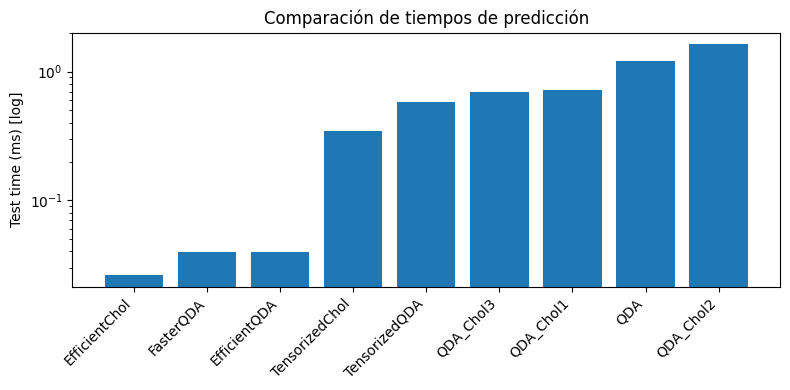

In [14]:
df = summ.copy()

if 'model' not in df.columns:
    df = df.reset_index(names='model')

df = df.sort_values('test_median_ms', ascending=True)

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['test_median_ms'])
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test time (ms) [log]')
plt.title('Comparación de tiempos de predicción')
plt.tight_layout()
plt.show()


#### Ordenados por menor uso de memoria en test (en train son similares)

In [15]:
#ordenado por tiempo
summ.sort_values('test_mem_median_mb')[['test_mem_median_mb','train_mem_median_mb']]

,test_mem_median_mb,train_mem_median_mb
model,,
QDA_Chol3,0.007965,0.018333
QDA,0.008101,0.018402
QDA_Chol1,0.008110,0.018478
QDA_Chol2,0.008342,0.018105
TensorizedQDA,0.011993,0.018311
TensorizedChol,0.012833,0.018478
FasterQDA,0.058876,0.019165
EfficientQDA,0.058876,0.019463
EfficientChol,0.061203,0.018375


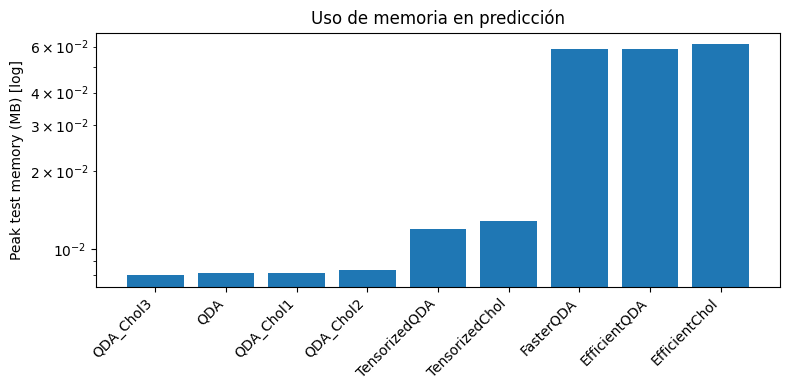

In [16]:
df = summ.copy()
if 'model' not in df.columns:
    df = df.reset_index(names='model')

df = df.sort_values('test_mem_median_mb', ascending=True)

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['test_mem_median_mb'])
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Peak test memory (MB) [log]')
plt.title('Uso de memoria en predicción')
plt.tight_layout()
plt.show()

#### La precision es muy alta y similar en todos

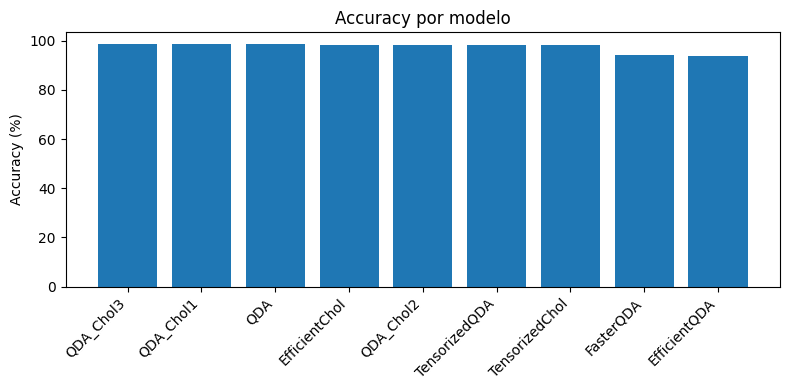

In [17]:
df = summ.copy()
if 'model' not in df.columns:
    df = df.reset_index(names='model')

df['acc_%'] = 100 * df['mean_accuracy']
df = df.sort_values('acc_%', ascending=False)

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['acc_%'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy por modelo')
plt.tight_layout()
plt.show()


## Importante:

Las métricas que se observan al realizar benchmarking son muy dependientes del código que se ejecuta, y por tanto de las versiones de las librerías utilizadas. Una forma de unificar esto es utilizando un gestor de versiones y paquetes como _uv_ o _Poetry_, otra es simplemente usando una misma VM como la que provee Colab.

**Cada equipo debe informar las versiones de Python, NumPy y SciPy con que fueron obtenidos los resultados. En caso de que sean múltiples, agregar todos los casos**. La siguiente celda provee una ayuda para hacerlo desde un notebook, aunque como es una secuencia de comandos también sirve para consola.

In [18]:
# Version que deberia funcionar en todos los entornos

import sys
print("Python:", sys.version)

# importlib.metadata es estándar desde Python 3.8; en Colab también está.
try:
    from importlib.metadata import version, PackageNotFoundError
except Exception:
    from importlib_metadata import version, PackageNotFoundError  # backport, por si acaso

for pkg in ["numpy", "scipy"]:
    try:
        print(f"{pkg}:", version(pkg))
    except PackageNotFoundError:
        print(f"{pkg}: NO INSTALADO")

Python: 3.11.13 (main, Jun 12 2025, 12:22:50) [Clang 20.1.4 ]
numpy: 2.3.2
scipy: 1.16.1


Versiones

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

numpy: 2.0.2

scipy: 1.16.1